Using random forests to predict the survival of titanic passengers. I have loosely followed this tutorial, though it uses a different library:
(https://www.kaggle.com/code/gusthema/titanic-competition-w-tensorflow-decision-forests)

In [343]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt

In [344]:
train_df = pd.read_csv("titanic/train.csv")
serving_df = pd.read_csv("titanic/test.csv")

In [345]:
label_encoder = LabelEncoder()
ordinal_encoder = OrdinalEncoder()
one_hot_encoder = OneHotEncoder()

In [346]:
def preprocess(df):
    df = df.copy()

    #Normalise the name column by removing any punctuation
    def normalize_name(x: str) -> str:
        return " ".join([v.strip(",()[].\"'") for v in x.split(" ")])

    #Split the ticket column into "item" suffix, and ticket number columns
    def ticket_number(x: str) -> int:
        return x.split(" ")[-1]
        
    def ticket_item(x: str) -> str:
        items = x.split(" ")
        if len(items) == 1:
            return "NONE"
        return "_".join(items[0:-1])
    
    df["Name"] = df["Name"].apply(normalize_name)
    df["Ticket_number"] = df["Ticket"].apply(ticket_number)
    df["Ticket_item"] = df["Ticket"].apply(ticket_item)                     
    return df
    
df = preprocess(train_df)
preprocessed_serving_df = preprocess(serving_df)

df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_number,Ticket_item
0,1,0,3,Braund Mr Owen Harris,male,22.0,1,0,A/5 21171,7.2500,NaN,S,21171,A/5
1,2,1,1,Cumings Mrs John Bradley Florence Briggs Thayer,female,38.0,1,0,PC 17599,71.2833,C85,C,17599,PC
2,3,1,3,Heikkinen Miss Laina,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3101282,STON/O2.
3,4,1,1,Futrelle Mrs Jacques Heath Lily May Peel,female,35.0,1,0,113803,53.1000,C123,S,113803,NONE
4,5,0,3,Allen Mr William Henry,male,35.0,0,0,373450,8.0500,NaN,S,373450,NONE


The tutorial I am following uses tensorflow, which "can consume text tokens natively". Since the library we are using cannot, I will look into the name column to see what the most relevant information is in there. I expect that title and last name will be most relevant and useful.

In [347]:
df['Name'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 891 entries, 0 to 890
Series name: Name
Non-Null Count  Dtype 
--------------  ----- 
891 non-null    object
dtypes: object(1)
memory usage: 7.1+ KB


In [348]:
df['Name'] = df['Name'].dropna()

In [349]:
df['Title'] = df.Name.str.extract(r' (\S+) ')
df['Last Name'] = df.Name.str.extract(r'^(\S+) ')
df['First Name'] = df.Name.str.extract(r' (\S+ \S+)')
df['First Name'] = df['First Name'].str.extract(r' (\S+)')

#Remove whitespace
df['Title'] = df['Title'].str.strip()
df['Last Name'] = df['Last Name'].str.strip()
df['First Name'] = df['First Name'].str.strip()

This must be an awful way of extracting the first name but it works. Sorry.

In [350]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_number,Ticket_item,Title,Last Name,First Name
0,1,0,3,Braund Mr Owen Harris,male,22.0,1,0,A/5 21171,7.2500,NaN,S,21171,A/5,Mr,Braund,Owen
1,2,1,1,Cumings Mrs John Bradley Florence Briggs Thayer,female,38.0,1,0,PC 17599,71.2833,C85,C,17599,PC,Mrs,Cumings,John
2,3,1,3,Heikkinen Miss Laina,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3101282,STON/O2.,Miss,Heikkinen,Laina
3,4,1,1,Futrelle Mrs Jacques Heath Lily May Peel,female,35.0,1,0,113803,53.1000,C123,S,113803,NONE,Mrs,Futrelle,Jacques
4,5,0,3,Allen Mr William Henry,male,35.0,0,0,373450,8.0500,NaN,S,373450,NONE,Mr,Allen,William


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30],
 [Text(0, 0, 'Mlle'),
  Text(1, 0, 'Messemaeker'),
  Text(2, 0, 'the'),
  Text(3, 0, 'Mulder'),
  Text(4, 0, 'Ms'),
  Text(5, 0, 'Mme'),
  Text(6, 0, 'Gordon'),
  Text(7, 0, 'Mrs'),
  Text(8, 0, 'y'),
  Text(9, 0, 'Miss'),
  Text(10, 0, 'Master'),
  Text(11, 0, 'Col'),
  Text(12, 0, 'Major'),
  Text(13, 0, 'Dr'),
  Text(14, 0, 'Mr'),
  Text(15, 0, 'Rev'),
  Text(16, 0, 'Carlo'),
  Text(17, 0, 'der'),
  Text(18, 0, 'Walle'),
  Text(19, 0, 'Velde'),
  Text(20, 0, 'Steen'),
  Text(21, 0, 'Shawah'),
  Text(22, 0, 'Jonkheer'),
  Text(23, 0, 'Planke'),
  Text(24, 0, 'Pelsmaeker'),
  Text(25, 0, 'Cruyssen'),
  Text(26, 0, 'Don'),
  Text(27, 0, 'Capt'),
  Text(28, 0, 'Impe'),
  Text(29, 0, 'Melkebeke'),
  Text(30, 0, 'Billiard')])

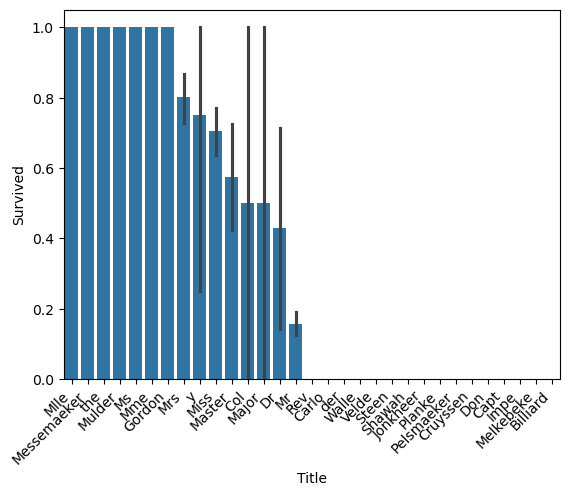

In [351]:
order = df.groupby('Title')['Survived'].mean().sort_values(ascending=False).index
sns.barplot(y=df['Survived'], x=df['Title'], order=order)
plt.xticks(rotation=45, ha='right')

In [352]:
df['Title'].value_counts()

Title
Mr             502
Miss           179
Mrs            121
Master          40
Dr               7
Rev              6
y                4
Planke           3
Impe             3
Gordon           2
Col              2
Mlle             2
Major            2
Melkebeke        1
Jonkheer         1
Shawah           1
the              1
Velde            1
Capt             1
Messemaeker      1
Carlo            1
Ms               1
Mme              1
Steen            1
Mulder           1
Pelsmaeker       1
Walle            1
der              1
Billiard         1
Don              1
Cruyssen         1
Name: count, dtype: int64

There is very little data for a lot of the titles, meaning the model will probably make some incorrect assumptions based on it. To solve this, I will group together all of the titles other than ['Mr','Mrs','Miss','Master','Dr','Rev']

In [353]:
titles = ['Mr','Mrs','Miss','Master','Dr','Rev']
df.loc[~df['Title'].isin(titles),'Title'] = 'Other'

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Mrs'),
  Text(1, 0, 'Miss'),
  Text(2, 0, 'Master'),
  Text(3, 0, 'Dr'),
  Text(4, 0, 'Other'),
  Text(5, 0, 'Mr'),
  Text(6, 0, 'Rev')])

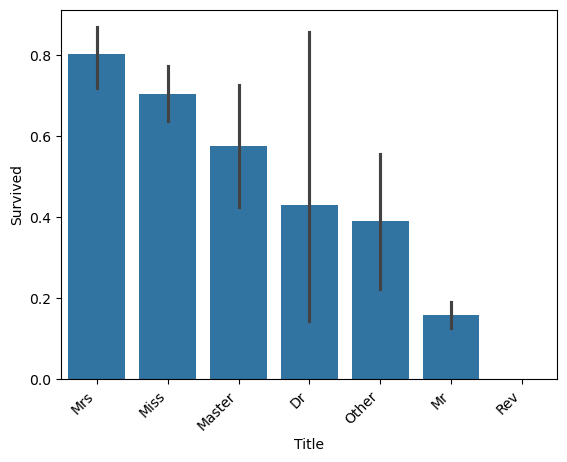

In [354]:
order = df.groupby('Title')['Survived'].mean().sort_values(ascending=False).index
sns.barplot(y=df['Survived'], x=df['Title'], order=order)
plt.xticks(rotation=45, ha='right')

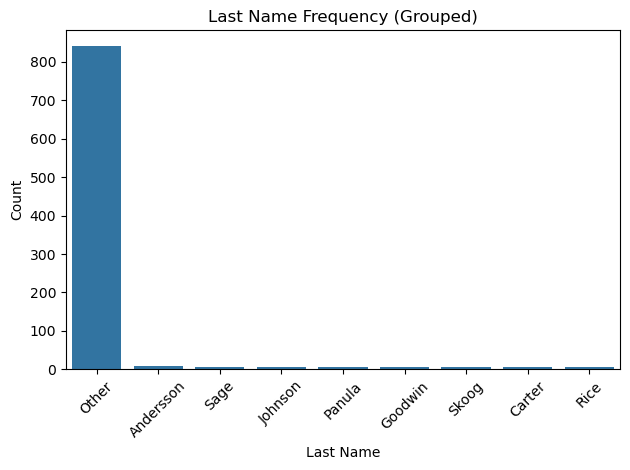

In [355]:
# Step 1: Count occurrences of each name
name_counts = df['Last Name'].value_counts()

# Step 2: Create a new column with 'Other' for names appearing <5 times
df['name_grouped'] = df['Last Name'].apply(lambda name: name if name_counts[name] >= 5 else 'Other')

# Step 3: Count the grouped names
grouped_counts = df['name_grouped'].value_counts().sort_values(ascending=False)

# Step 4: Plot using Seaborn or Matplotlib
sns.barplot(x=grouped_counts.index, y=grouped_counts.values)
plt.xticks(rotation=45)
plt.xlabel('Last Name')
plt.ylabel('Count')
plt.title('Last Name Frequency (Grouped)')
plt.tight_layout()
plt.show()

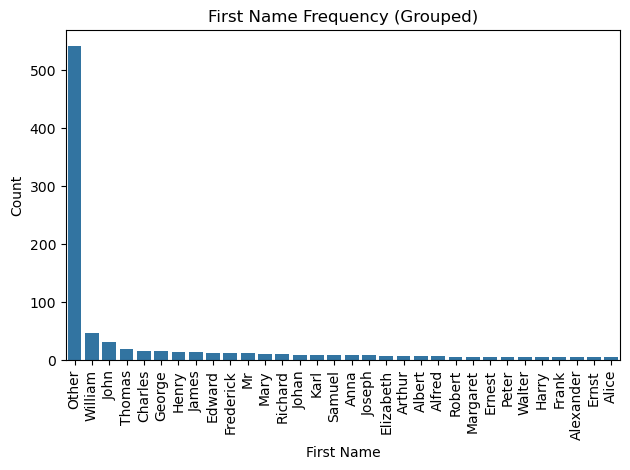

In [356]:
# Step 1: Count occurrences of each name
name_counts = df['First Name'].value_counts()

# Step 2: Create a new column with 'Other' for names appearing <5 times
df['name_grouped'] = df['First Name'].apply(lambda name: name if name_counts[name] >= 5 else 'Other')

# Step 3: Count the grouped names
grouped_counts = df['name_grouped'].value_counts().sort_values(ascending=False)

# Step 4: Plot using Seaborn or Matplotlib
sns.barplot(x=grouped_counts.index, y=grouped_counts.values)
plt.xticks(rotation=90)
plt.xlabel('First Name')
plt.ylabel('Count')
plt.title('First Name Frequency (Grouped)')
plt.tight_layout()
plt.show()

It seems that First Name is more useful than Last Name. I think that there are too many values within these columns for either of them to be worth encoding, though. Doing so would probably make our model overfitted to the training data. I will encode just the "title" column

In [357]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Ticket_number',
       'Ticket_item', 'Title', 'Last Name', 'First Name', 'name_grouped'],
      dtype='object')

In [358]:
df = df.drop('name_grouped', axis=1)

In [359]:
sex_encoder = OrdinalEncoder()
embarked_encoder = OrdinalEncoder()

df['Sex'] = sex_encoder.fit_transform(df[['Sex']])
df['Embarked'] = embarked_encoder.fit_transform(df[['Embarked']])

# LabelEncoder needs 1D input
ticket_encoder = LabelEncoder()
title_encoder = LabelEncoder()

df['Ticket_item'] = ticket_encoder.fit_transform(df['Ticket_item'])
df['Title'] = title_encoder.fit_transform(df['Title'])

In [360]:
df = df[pd.to_numeric(df['Ticket_number'], errors='coerce').notnull()]

In [361]:
X_columns = list(df.columns)
X_columns.remove("Ticket")
X_columns.remove("PassengerId")
X_columns.remove("Survived")
X_columns.remove("Cabin")
X_columns.remove("Last Name")
X_columns.remove("First Name")
X_columns.remove("Name")
X_train = df[X_columns]

y_train = df["Survived"]

print(f"Input features: {X_columns}")

Input features: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Ticket_number', 'Ticket_item', 'Title']


In [362]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_number,Ticket_item,Title,Last Name,First Name
0,1,0,3,Braund Mr Owen Harris,1.0,22.0,1,0,A/5 21171,7.2500,NaN,2.0,21171,4,3,Braund,Owen
1,2,1,1,Cumings Mrs John Bradley Florence Briggs Thayer,0.0,38.0,1,0,PC 17599,71.2833,C85,0.0,17599,18,4,Cumings,John
2,3,1,3,Heikkinen Miss Laina,0.0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,2.0,3101282,37,2,Heikkinen,Laina
3,4,1,1,Futrelle Mrs Jacques Heath Lily May Peel,0.0,35.0,1,0,113803,53.1000,C123,2.0,113803,16,4,Futrelle,Jacques
4,5,0,3,Allen Mr William Henry,1.0,35.0,0,0,373450,8.0500,NaN,2.0,373450,16,3,Allen,William


In [363]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_number,Ticket_item,Title,Last Name,First Name
0,1,0,3,Braund Mr Owen Harris,1.0,22.0,1,0,A/5 21171,7.2500,NaN,2.0,21171,4,3,Braund,Owen
1,2,1,1,Cumings Mrs John Bradley Florence Briggs Thayer,0.0,38.0,1,0,PC 17599,71.2833,C85,0.0,17599,18,4,Cumings,John
2,3,1,3,Heikkinen Miss Laina,0.0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,2.0,3101282,37,2,Heikkinen,Laina
3,4,1,1,Futrelle Mrs Jacques Heath Lily May Peel,0.0,35.0,1,0,113803,53.1000,C123,2.0,113803,16,4,Futrelle,Jacques
4,5,0,3,Allen Mr William Henry,1.0,35.0,0,0,373450,8.0500,NaN,2.0,373450,16,3,Allen,William


In [364]:
clf = RandomForestClassifier(max_depth = 1, random_state = 1)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=1, random_state=1)

In [365]:
preprocessed_serving_df['Name'] = preprocessed_serving_df['Name'].dropna()
preprocessed_serving_df['Title'] = preprocessed_serving_df.Name.str.extract(r' (\S+) ')
preprocessed_serving_df['Last Name'] = preprocessed_serving_df.Name.str.extract(r'^(\S+) ')
preprocessed_serving_df['First Name'] = preprocessed_serving_df.Name.str.extract(r' (\S+ \S+)')
preprocessed_serving_df['First Name'] = preprocessed_serving_df['First Name'].str.extract(r' (\S+)')

#Remove whitespace
preprocessed_serving_df['Title'] = preprocessed_serving_df['Title'].str.strip()
preprocessed_serving_df['Last Name'] = preprocessed_serving_df['Last Name'].str.strip()
preprocessed_serving_df['First Name'] = preprocessed_serving_df['First Name'].str.strip()

titles = ['Mr','Mrs','Miss','Master','Dr','Rev']
preprocessed_serving_df.loc[~preprocessed_serving_df['Title'].isin(titles),'Title'] = 'Other'

sex_encoder = OrdinalEncoder()
embarked_encoder = OrdinalEncoder()

preprocessed_serving_df['Sex'] = sex_encoder.fit_transform(preprocessed_serving_df[['Sex']])
preprocessed_serving_df['Embarked'] = embarked_encoder.fit_transform(preprocessed_serving_df[['Embarked']])

# LabelEncoder needs 1D input
ticket_encoder = LabelEncoder()
title_encoder = LabelEncoder()

preprocessed_serving_df['Ticket_item'] = ticket_encoder.fit_transform(preprocessed_serving_df['Ticket_item'])
preprocessed_serving_df['Title'] = title_encoder.fit_transform(preprocessed_serving_df['Title'])

preprocessed_serving_df = preprocessed_serving_df[pd.to_numeric(preprocessed_serving_df['Ticket_number'], errors='coerce').notnull()]

X_test = preprocessed_serving_df[X_columns]

In [366]:
y_pred =clf.predict(X_test)

In [367]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [368]:
sub = pd.DataFrame({'PassengerId':preprocessed_serving_df['PassengerId'], 'Survived':y_pred})

In [369]:
sub.to_csv('submission_7.csv', index=False)

This submission achieved a score of 0.78468 with a max_depth of 5

By increasing the max_depth to 10, the accuracy score dropped to exactly the same as predicting that only and exclusively females survived (0.76555)

With a max_depth of 3, the accuracy was higher still, at 0.78708. A max_depth of 2 scored 0.7799, and a max_depth of one scored 0.77511

It seems that it doesn't take much depth to overfit the training data